# 1 visible the data
Always the first thing is to visible the data. I generate the data from the simulator, but I found that the dataset is too small, then I directly use data from udacity, the code is below

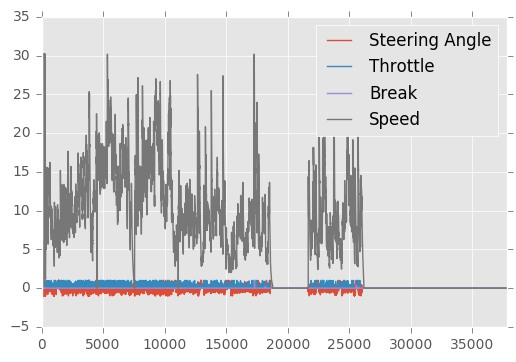

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')
drivingLog = pd.read_csv('driving_log_20.csv',names=['Center','Left','Right','Steering Angle','Throttle','Break','Speed'],header=None)

plt.figure(figsize=(20,10));
drivingLog.plot();

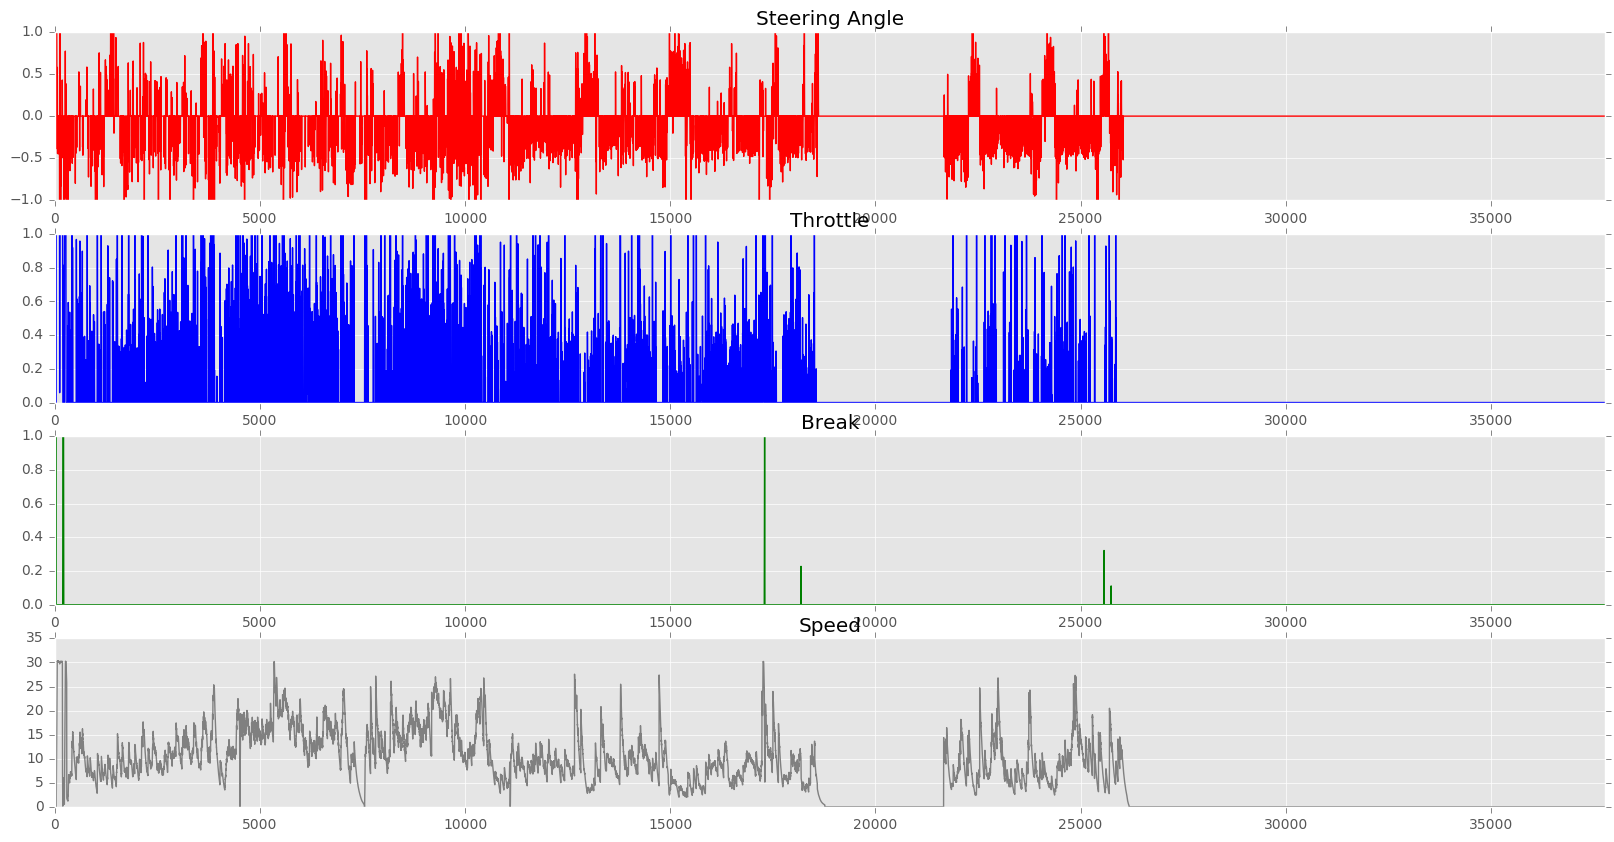

In [47]:
fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(20,10))
drivingLog['Steering Angle'].plot(ax=axes[0],color='red'); axes[0].set_title('Steering Angle');
drivingLog['Throttle'].plot(ax=axes[1],color='blue'); axes[1].set_title('Throttle');
drivingLog['Break'].plot(ax=axes[2],color='green'); axes[2].set_title('Break');
drivingLog['Speed'].plot(ax=axes[3],color='gray'); axes[3].set_title('Speed');

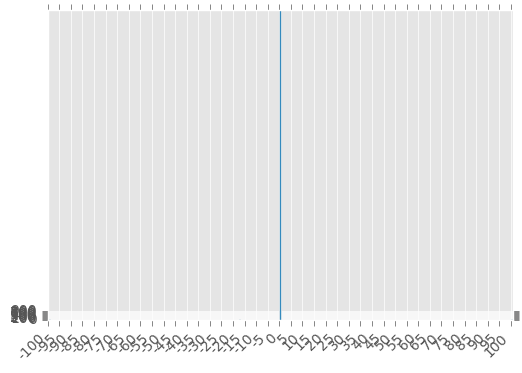

In [60]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import cv2


#read data from csv
class AngleNum(dict):
	def __missing__(self, key):
		return 0

angle_num = AngleNum()

#read data from csv,and count the angle num
with open('driving_log_20.csv') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
    	angle = round(float(row[3]),3)*100
    	angle_num[angle] = angle_num[angle]+1

        
labels=[]
label_num=[]

for (label, num) in angle_num.items():
    labels.append(label)
    label_num.append(num)

x_label = np.arange(-150,150,5)
y_label = np.arange(0,1000,100)
plt.xticks(x_label,x_label,ha='right',rotation=45)
plt.yticks(y_label,y_label)
plt.bar(labels,label_num)
plt.show()

It's seems that the zero angle is too big

In [61]:
print('angle zero:',angle_num[0])
sum=0
for (key,num) in angle_num.items():
    sum+=num
print('angle sum:',sum)

angle zero: 30299
angle sum: 37781


there are 37781 record, 0 angle is about 30000, in order to make the data more flat, I use just try 30, 100 and -100 is also wired, just delet it 

20 0 0
0 0
7339


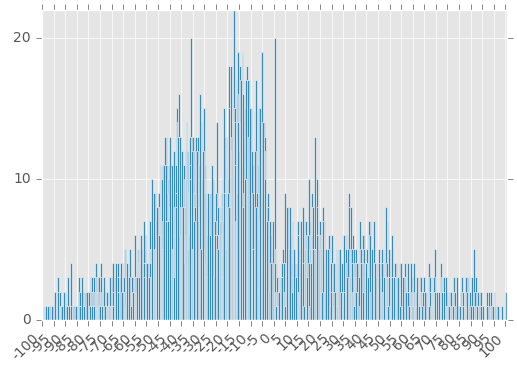

In [63]:
labels=[]
label_num=[]
print(angle_num[0],angle_num[100],angle_num[-100])
angle_num[0]=20
angle_num[100]=angle_num[-100]=0
print(angle_num[100],angle_num[-100])
sum=0
for (label, num) in angle_num.items():
    labels.append(label)
    label_num.append(num)
    if label!=0:
        sum+=num
    
print(sum)

x_label = np.arange(-150,150,5)
y_label = np.arange(0,100,10)
plt.xticks(x_label,x_label,ha='right',rotation=45)
plt.yticks(y_label,y_label)
plt.bar(labels,label_num)
plt.show()

It seems good. so I will only choose 20/30000 zero angle of dataset. maybe implement a mean distrubition later. 

0 degree num: 4361


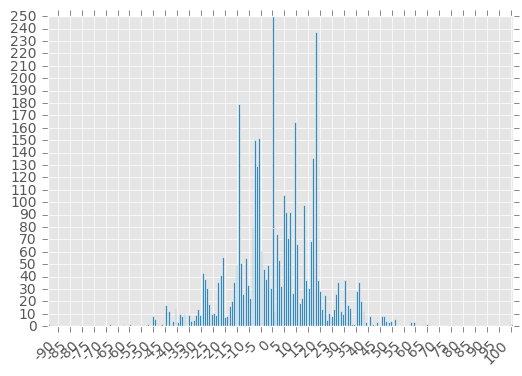

In [64]:
class AngleNum1(dict):
	def __missing__(self, key):
		return 0

angle_num_m = AngleNum1()

with open('data/driving_log.csv') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
    	angle_m = round(float(row[3]),3)*100
    	angle_num_m[angle_m] = angle_num_m[angle_m]+1

labels_m=[]
labels_num_m=[]
print('0 degree num:',angle_num_m[0])
angle_num_m[0]=250
for (label, num) in angle_num_m.items():
    labels_m.append(label)
    labels_num_m.append(num)


    
x_label = np.arange(-150,150,5)
y_label = np.arange(0,300,10)
plt.xticks(x_label,x_label,ha='right',rotation=45)
plt.yticks(y_label,y_label)
plt.bar(labels_m,labels_num_m)
plt.show()

In [ ]:
we will use 250/4361 0 degree

##  2 Data augmentation

now the sum of image is about 4000+, too small,so we use ImageDataGenerator from [keras's blog said ](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) to generator more training data, we use i=4 to control the datagenerator

In [8]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import json
import random
from PIL import Image



datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

def genImg(img_path):
    img = Image.open(img_path)  # this is a PIL image
    x = np.array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `preview/` directory
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir='data/IMG_EXTRA', save_prefix='car', save_format='jpeg'):
        i += 1
        if i > 4:
            break  # otherwise the generator would loop indefinitely

with open('data/driving_log.csv') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
        angle = float(row[3].strip())
        if angle==0:
            if random.random() > 0.06: # do nothing,just not use this data
                pass
            else:
                genImg('data/'+row[0])
        else:
            genImg('data/'+row[0])



## 1.2 Combine and Crop the image 
now we combine the two dataset, then crop image, store the image and angle in x_train and y_train

In [105]:
#read data from csv，only choose 3/20 of the zero angle, then brightness and shadow the image
import random
from PIL import Image

x_train =[]
y_train =[]

def crop_img(image_path):
    im = Image.open('data/'+image_path)
    im = im.crop((0,im.size[1]/3,im.size[0],im.size[1]-25)) #crop the top 1/5 and the bottom 25 pix down
    return im

def crop_img_m(image_path):
    im = Image.open(image_path)
    im = im.crop((0,im.size[1]/3,im.size[0],im.size[1]-25)) #crop the top 1/5 and the bottom 25 pix down
    return im
    

with open('data/driving_log.csv') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
        angle = float(row[3].strip())
        if angle==0:
            if random.random() > 0.06: # do nothing,just not use this data
                pass
            else:
                im=crop_img(row[0])
                x_train.append(np.array(im))
                y_train.append(angle)
        else:
            im=crop_img(row[0])
            x_train.append(np.array(im))
            y_train.append(angle)
            
with open('driving_log_20.csv') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
        angle = float(row[3].strip())
        if angle==0 or angle==1 or angle==-1: # do nothing,just not use the data too sharper
                pass
        else:
            im=crop_img_m(row[0])
            x_train.append(np.array(im))
            y_train.append(angle)            

print('x_train',np.array(x_train).shape)
print('y_train',np.array(y_train).shape, y_train.count(0))


x_train (11431, 82, 320, 3)
y_train (11431,) 272


## 1.3 Brightness the image
so, our data set is about 11426 image, to avoid overfit, I use the method from vivek ['proprocess image'](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.ha7vqfcfp),so we add  some brightness and shadow to the image, code that brightness the image:        

In [79]:
# add random brightness to the image
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .5+ np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

for i in range(len(x_train)):
    x_train_br[i] = augment_brightness_camera_images(np.array(x_train[i]))
                    

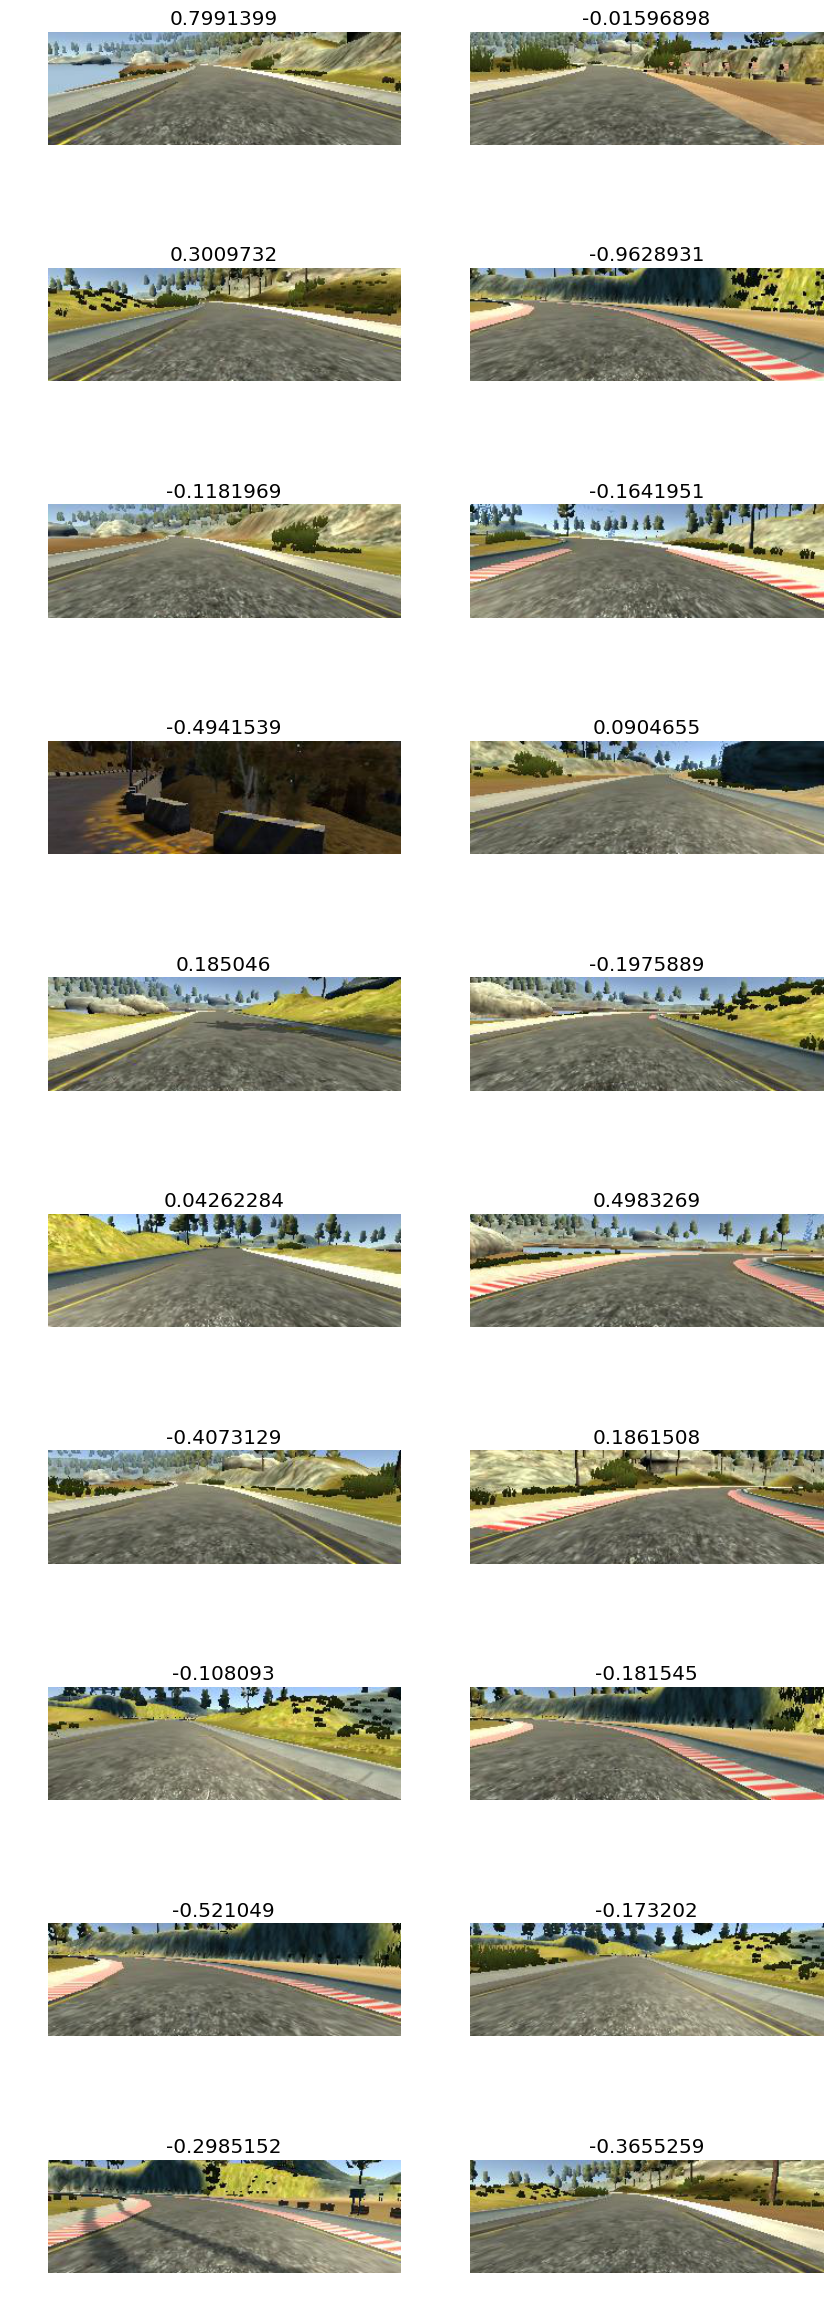

In [83]:
#show some images
x_len = len(x_train)
figure = plt.figure(figsize=(10,30))
factors = [10,2]
for ind in range(20):
    img = figure.add_subplot(factors[0],factors[1],ind + 1)
    i = random.randint(0,x_len)  #select a random image
    val = np.array(x_train[i])
    plt.axis("off")
    img.set_title(y_train[i])    
    plt.imshow(val, cmap='gray')
    

## 1.4 Shadow the image
then add some shadow to the image:

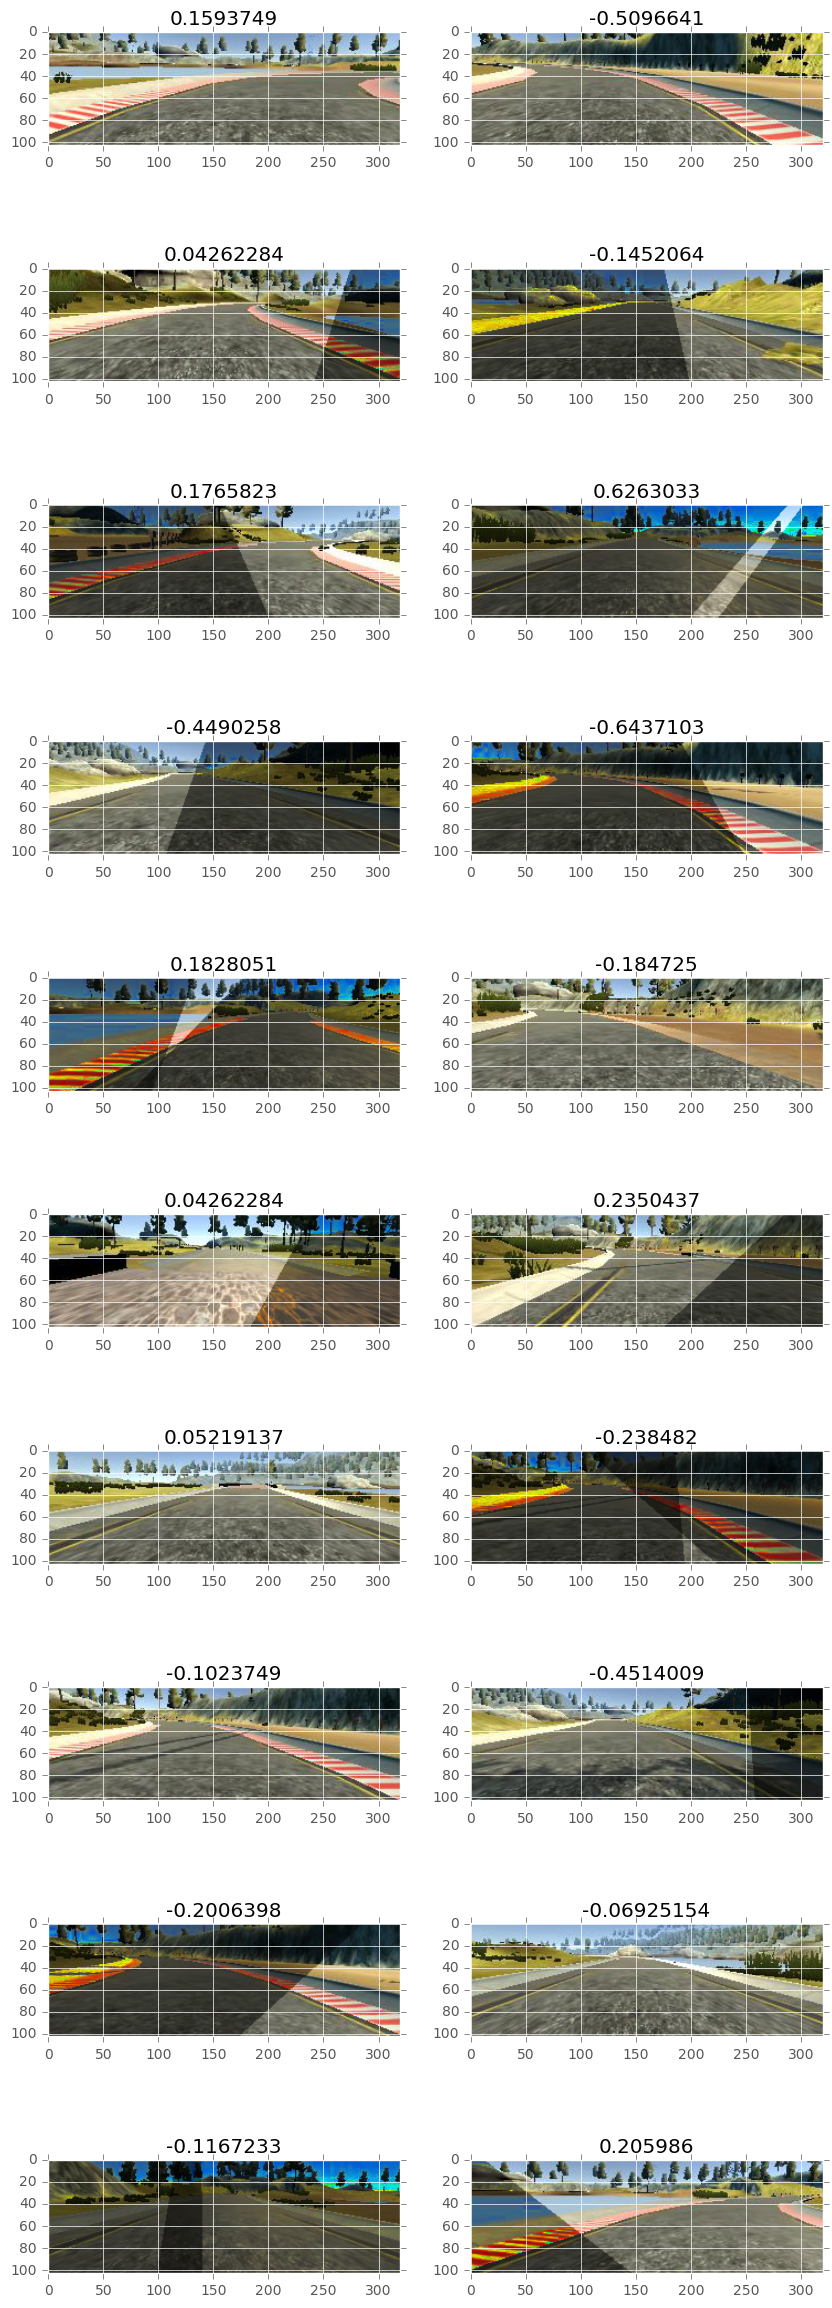

In [85]:
def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

for i in range(len(x_train)):
    x_train[i] = add_random_shadow(np.array(x_train[i]))

x_len = len(x_train)
figure = plt.figure(figsize=(10,30))
factors = [10,2]
    
for ind in range(20):
    img = figure.add_subplot(factors[0],factors[1],ind + 1)
    i = random.randint(0,x_len)
    val = np.array(x_train[i])
    img.set_title(y_train[i])
    plt.imshow(val, cmap='gray')

## 1.5 resize the image
the image is too big, so I first resize the image to 64x64

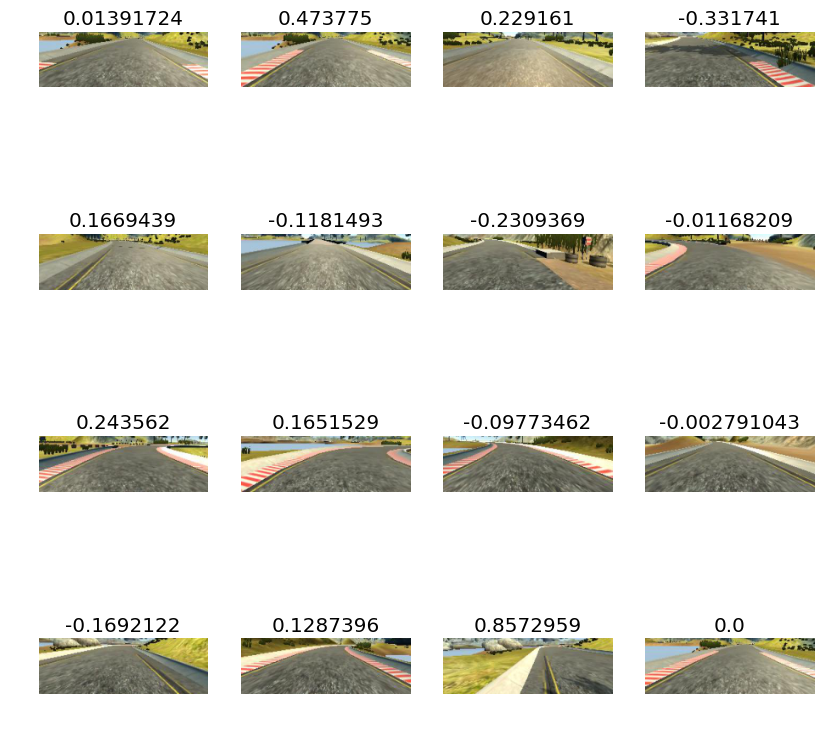

In [106]:
for i in range(len(x_train)):
    x_train[i] = cv2.resize(np.array(x_train[i]),(200,66),interpolation=cv2.INTER_AREA) 

x_len = len(x_train)
figure = plt.figure(figsize=(10,10))
factors = [4,4]
    
for ind in range(16):
    img = figure.add_subplot(factors[0],factors[1],ind + 1)
    i = random.randint(0,x_len)
    val = np.array(x_train[i])
    img.set_title(y_train[i])
    plt.axis("off")
    plt.imshow(val, cmap='gray')

# 2 split the valid data and the test data

In [107]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

x_train, y_train = shuffle(x_train, y_train)
x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape)


#split the data to train and test
train_features, test_features, train_labels, test_labels = train_test_split(
    x_train,
    y_train,
    test_size=0.1,
    random_state=40)


#split the data to train and valid
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.2,
    random_state=11)

(11431, 66, 200, 3)


# 3 Architechture
I use Nivida modal which like that, which I changed to 'elu', and add 'dropout' layer to avoid overfit

In [115]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten,Dropout,Lambda
from keras.layers.convolutional import Convolution2D




model = Sequential()
model.add(Lambda(lambda x: x/255.-0.5, input_shape=(33,100,3),))
model.add(Convolution2D(24, 5, 5, border_mode='same', subsample=(2,2)))
model.add(Activation('elu'))
model.add(Convolution2D(36, 5, 5, border_mode='same', subsample=(2,2)))
model.add(Activation('elu'))
model.add(Convolution2D(48, 5, 5, border_mode='same', subsample=(2,2)))
model.add(Activation('elu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('elu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('elu'))
model.add(Flatten())
model.add(Dense(1164))
model.add(Activation('elu'))
model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('elu'))
model.add(Dropout(0.5))

model.add(Dense(1,name='output'))
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_8 (Lambda)                (None, 33, 100, 3)    0           lambda_input_8[0][0]             
____________________________________________________________________________________________________
convolution2d_26 (Convolution2D) (None, 17, 50, 24)    1824        lambda_8[0][0]                   
____________________________________________________________________________________________________
activation_46 (Activation)       (None, 17, 50, 24)    0           convolution2d_26[0][0]           
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 9, 25, 36)     21636       activation_46[0][0]              
___________________________________________________________________________________________

# 4 Make them all and run
now the sum of image is about 4000+, too small,so we use ImageDataGenerator from [keras's blog said ](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) to generator more training data

In [134]:
x_train =[]
y_train =[]


def crop_img(image_path):
    im = Image.open(image_path)
    im = im.crop((0,im.size[1]/3,im.size[0],im.size[1]-25)) #crop the top 1/5 and the bottom 25 pix down
    im = im.resize((100,33))
    return im
'''
with open('data/driving_log.csv') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
        angle = float(row[3].strip())
        if angle==0:
            if random.random() > 0.08: # do nothing,just not use this data
                pass
            else:
                im=crop_img('data/'+row[0])
                x_train.append(np.array(im))
                y_train.append(angle)
        else:
            im=crop_img('data/'+row[0])
            x_train.append(np.array(im))
            y_train.append(angle)
            
            if(angle>0.3 or angle<-0.3):                
                imageFlipped = cv2.flip(np.array(im), 1)
                x_train.append(imageFlipped)
                y_train.append(-angle)
                
'''            
            
with open('driving_log_20.csv') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
        angle = float(row[3].strip())
        if angle==0 or angle==1 or angle==-1: # do nothing,just not use the data too sharper
                pass
        else:
            im=crop_img(row[0])
            x_train.append(np.array(im))
            y_train.append(angle)  
            
            if(angle>0.3 or angle<-0.3):                
                imageFlipped = cv2.flip(np.array(im), 1)
                x_train.append(imageFlipped)
                y_train.append(-angle)
                

print('loading data finished')

loading data finished


In [139]:
print(len(y_train))

11035


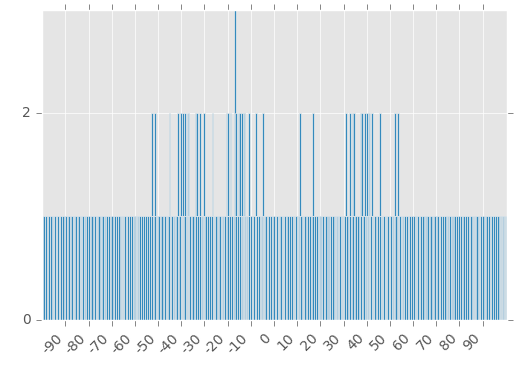

In [137]:
y_num = AngleNum()

#show the angle distrubition
for angle in y_train:
    y_num[angle*100] = y_num[angle*100]+1
    
        
labels_m=[]
labels_num_m=[]
for (label, num) in y_num.items():
    labels_m.append(label)
    labels_num_m.append(num)


x_label = np.arange(-100,100,10)
y_label = np.arange(0,20,2)
plt.xticks(x_label,x_label,ha='right',rotation=45)
plt.yticks(y_label,y_label)
plt.bar(labels_m,labels_num_m)
plt.show()

In [ ]:
x_train, y_train = shuffle(x_train, y_train)

x_train = np.array(x_train)
y_train = np.array(y_train)


print(x_train.shape)

#split the data to train and test
train_features, test_features, train_labels, test_labels = train_test_split(
    x_train,
    y_train,
    test_size=0.1,
    random_state=40)


#split the data to train and valid
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.2,
    random_state=11)

In [126]:
from keras.optimizers import Adam
import json

model.compile(loss='mse',optimizer=Adam(lr=0.001),metrics=['accuracy'])

#we use samples 4*len(x_train)
#model.fit_generator(datagen.flow(train_features, train_labels, batch_size=32),
#                    samples_per_epoch=20000, nb_epoch=2)

def generator_data(x_set,y_set,batch_size):
    i=0
    while 1:   	
    	for (x_data,y_data) in zip(x_set,y_set):	    		          	
	    	x_data= np.expand_dims(x_data,axis=0)
	    	y_data= np.expand_dims(y_data,axis=0)
	    	yield(x_data,y_data)
            
data_generator = generator_data(train_features, train_labels,1)
valid_generator = generator_data(valid_features, valid_labels,1)

model.fit_generator(data_generator, samples_per_epoch = 12000,
                   nb_epoch=2, validation_data = valid_generator,
                   nb_val_samples = 400)


score = model.evaluate(test_features, test_labels, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

json_string = model.to_json()
model.save_weights('model.h5')
with open('model.json', 'w') as outfile:
	json.dump(model.to_json(), outfile)

Epoch 1/2
12000/12000 [==============================] - 373s - loss: 227.1160 - acc: 0.0329 - val_loss: 0.1038 - val_acc: 0.0200
Epoch 2/2
12000/12000 [==============================] - 385s - loss: 128.7796 - acc: 0.0325 - val_loss: 0.0908 - val_acc: 0.0250
Test score: 0.0926158055008
Test accuracy: 0.0281195079152
